In [1]:
%%html
<style>
/*overwrite hard coded write background by vscode for ipywidges */
.cell-output-ipywidget-background {
background-color: transparent !important;
}
/*set widget foreground text and color of interactive widget to vs dark theme color */
:root {
--jp-widgets-color: var(--vscode-editor-foreground);
--jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
from scipy.signal import find_peaks, peak_widths

In [36]:
# sheets importieren
sheet_names = [
    "Na22",
    "Cs",
    "Co",
    "Schutz",
    "Nackt",
    "K2CO3",
    "Melke die Molke",
    "Uranoxid",
    "Thor",
    "Pilze nur Pilze",
]
sheets = [pd.read_excel("RAD.xlsx", sheet_name=name) for name in sheet_names]
sheets = (
    pd.concat(dict(zip(sheet_names, sheets)))
    .drop(columns=["n_A#2", "N_A#2", "n_A#3", "N_A#3"])
    .rename(columns={"n_A": "Channel", "N_A": "Events"})
    .reset_index()
    .set_index(["level_0", "Channel"])
    .drop(columns="level_1")
)
sheets

Events
level_0         Channel        
Na22            0             6
                1            14
                2             9
                3             7
                4             3
...                         ...
Pilze nur Pilze 1019          0
                1020          0
                1021          0
                1022          0
                1023        984

[10240 rows x 1 columns]

[ 4.92708333 75.4714795  16.70553876 23.81349206]


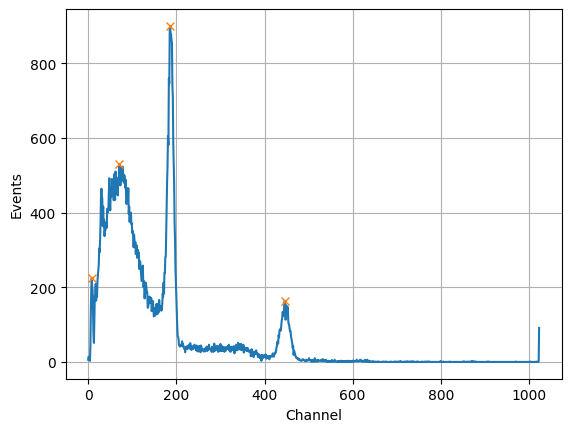

In [55]:
# peaks finden
series = "Na22"
peaks = find_peaks(sheets.loc[series, "Events"], prominence=150)[0]
# unsicherheiten bestimmen
widths = peak_widths(sheets.loc[series, "Events"], peaks)[0]

plt.plot(sheets.loc[series, "Events"])
plt.plot(peaks, sheets.loc[series, "Events"][peaks], "x")
plt.grid(True)
plt.xlabel("Channel")
plt.ylabel("Events")

print(widths)